In [1]:
# Goal: Redo the old shitty blackbody fits
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
warnings.filterwarnings("ignore", module="speclite.filters")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology
import seaborn
import pandas as pd

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.blackbody as blackbody
import snelib19odp.analysis.blackbody as bbfit

def plot_data(data, ax1, ax2, label, mjd_peak):
    #mjd_grid, data = data
    mjd_grid = np.array([x.mjd for x in data])
    temps = np.empty_like(mjd_grid)
    temp_errs = np.empty_like(mjd_grid)
    rads = np.empty_like(mjd_grid)
    rad_errs = np.empty_like(mjd_grid)
    for i, mjd in enumerate(mjd_grid):
        #obs_mags, obs_mags_errs, sampler, results = data[i]
        results = data[i].results
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
        trace = dyfunc.resample_equal(samples, weights)
        temps[i], temp_errs[i] = np.mean(trace[:,0]), np.std(trace[:,0])
        rads[i], rad_errs[i] = np.mean(trace[:,1]), np.std(trace[:,1])

    #mjd_peak = 58735
    ax1.errorbar(mjd_grid-mjd_peak, temps, yerr=temp_errs, label=label)
    ax2.errorbar(mjd_grid-mjd_peak, rads, yerr=rad_errs, label=label)
    
CM_TO_RSUN = u.cm.to(u.Rsun)
    
def plot_ds(ds, ax1, ax2, bands, fine=False):
    mjd_peak = ds.transient.prior_t0
    label = f"{ds.transient.name} {bands}"
    data = bbfit.run_observation_grid(ds, bands, progressbar=False, fine_pre_peak_grid=fine)
    #mjd_grid, data = data
    mjd_grid = np.array([x.mjd for x in data])
    temps = np.empty_like(mjd_grid)
    temp_errs = np.empty_like(mjd_grid)
    rads = np.empty_like(mjd_grid)
    rad_errs = np.empty_like(mjd_grid)
    for i, mjd in enumerate(mjd_grid):
        #obs_mags, obs_mags_errs, sampler, results = data[i]
        results = data[i].results
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
        trace = dyfunc.resample_equal(samples, weights)
        temps[i], temp_errs[i] = np.mean(trace[:,0]), np.std(trace[:,0])
        t_rads = np.log10(np.exp(trace[:,1])*CM_TO_RSUN)
        rads[i], rad_errs[i] = np.mean(t_rads), np.std(t_rads)

    #mjd_peak = 58735
    ax1.errorbar(mjd_grid-mjd_peak, temps, yerr=temp_errs, label=label)
    ax2.errorbar(mjd_grid-mjd_peak, rads, yerr=rad_errs, label=label)

Text(0, 0.5, 'Deviation %')

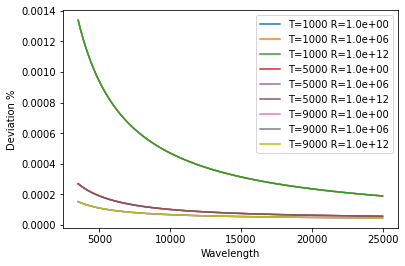

In [2]:
# Validation check 1: Double check that the bb function is correct
# copied from matts superbol:
def bbody(lam,T,R):
    '''
    Calculate the corresponding blackbody radiance for a set
    of wavelengths given a temperature and radiance.

    Parameters
    ---------------
    lam: Reference wavelengths in Angstroms
    T:   Temperature in Kelvin
    R:   Radius in cm

    Output
    ---------------
    Spectral radiance in units of erg/s/Angstrom

    (calculation and constants checked by Sebastian Gomez)
    '''

    # Planck Constant in cm^2 * g / s
    h = 6.62607E-27
    # Speed of light in cm/s
    c = 2.99792458E10

    # Convert wavelength to cm
    lam_cm = lam * 1E-8

    # Boltzmann Constant in cm^2 * g / s^2 / K
    k_B = 1.38064852E-16

    # Calculate Radiance B_lam, in units of (erg / s) / cm ^ 2 / cm
    exponential = (h * c) / (lam_cm * k_B * T)
    B_lam = ((2 * np.pi * h * c ** 2) / (lam_cm ** 5)) / (np.exp(exponential) - 1)

    # Multiply by the surface area
    A = 4*np.pi*R**2

    # Output radiance in units of (erg / s) / Angstrom
    Radiance = B_lam * A / 1E8

    return Radiance

wave_grid = np.arange(3500, 25000, 1)*1.0

for temp in [1000, 5000, 9000]:
    for r in [1, 1e6, 1e12]:
        bb_matt = bbody(wave_grid, temp, r)
        bb_mine = blackbody.bb(temp, r, wave_grid)
        plt.plot(wave_grid, (bb_mine/bb_matt - 1.0)*100, label='T=%.0f R=%.1e' % (temp, r))
plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Deviation %')

In [3]:
# Very slight numeric differences.. good enough for what we are doing!

In [4]:
dist_min, dist_max = (64-5)*u.Mpc.to(u.cm), (64+5)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='ri', dist_min=dist_min, dist_max=dist_max)

ds = dataset.load_dataset('SN2019odp_phot')
obs_mags, obs_mags_errs, sampler, results = bbfit.run_fit(ds, 58778, 'ri', func_setup)
print(results)
dyplot.cornerplot(results, show_titles=True, labels=['T', 'log R', 'D']);

58778


TypeError: 'int' object is not subscriptable

In [ ]:
dist_min, dist_max = (64-5)*u.Mpc.to(u.cm), (64+5)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='rizJH', dist_min=dist_min, dist_max=dist_max)

ds = dataset.load_dataset('SN2019odp_phot')
obs_mags, obs_mags_errs, sampler, results = bbfit.run_fit(ds, 58778, 'rizJH', func_setup)
dyplot.cornerplot(results, show_titles=True, labels=['T', 'log R', 'D']);

In [ ]:
dist_min, dist_max = (64-5)*u.Mpc.to(u.cm), (64+5)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='gri', dist_min=dist_min, dist_max=dist_max)

ds = dataset.load_dataset('SN2019odp_phot')
obs_mags, obs_mags_errs, sampler, results = bbfit.run_fit(ds, 58778, 'gri', func_setup)
dyplot.cornerplot(results, show_titles=True, labels=['T', 'log R', 'D']);

In [ ]:
dist_min, dist_max = (64-5)*u.Mpc.to(u.cm), (64+5)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='gr', dist_min=dist_min, dist_max=dist_max)

ds = dataset.load_dataset('SN2019odp_phot')
obs_mags, obs_mags_errs, sampler, results = bbfit.run_fit(ds, 58778, 'gr', func_setup)
dyplot.cornerplot(results, show_titles=True, labels=['T', 'log R', 'D']);

In [ ]:
ds.first_detection_mjd_band('J')

In [ ]:
ds = dataset.load_dataset('SN2019odp_phot')

mjd_grid_start = ds.first_detection_mjd_band('i')
print(mjd_grid_start)
mjd_grid_end = 58830
mjd_grid = np.linspace(mjd_grid_start, mjd_grid_end, 30)

dist_min, dist_max = (64-5)*u.Mpc.to(u.cm), (64+5)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='ri', dist_min=dist_min, dist_max=dist_max)

data_ri = []
for mjd in mjd_grid:
    print('MJD: ', mjd)
    x = bbfit.run_fit(ds, mjd, 'ri', func_setup)
    data_ri.append(x)
    

    #data_ri = (mjd_grid, data_ri)

In [ ]:
ds = dataset.load_dataset('SN2019odp_phot')
mjd_grid_start = ds.first_detection_mjd_band('i')
print(mjd_grid_start)
mjd_grid_end = 58830
mjd_grid = np.linspace(mjd_grid_start, mjd_grid_end, 30)

dist_min, dist_max = (64-5)*u.Mpc.to(u.cm), (64+5)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='gri', dist_min=dist_min, dist_max=dist_max)


data_gri = []
for mjd in mjd_grid:
    print('MJD: ', mjd)
    x = bbfit.run_fit(ds, mjd, 'gri', func_setup)
    data_gri.append(x)
    
#data_gri = (mjd_grid, data_gri)

In [ ]:
ds = dataset.load_dataset('SN2019odp_phot')
mjd_grid_start = ds.first_detection_mjd_band('J')
print(mjd_grid_start)
mjd_grid_end = 58810
mjd_grid = np.linspace(mjd_grid_start, mjd_grid_end, 10)

dist_min, dist_max = (64-5)*u.Mpc.to(u.cm), (64+5)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='rizJH', dist_min=dist_min, dist_max=dist_max)
ds = dataset.load_dataset('SN2019odp_phot')

data_grond = []
for mjd in mjd_grid:
    print('MJD: ', mjd)
    x = bbfit.run_fit(ds, mjd, 'rizJH', func_setup)
    data_grond.append(x)
    
#data_grond = (mjd_grid, data_grond)

In [ ]:
def plot_data(data, ax1, ax2, label):
    mjd_grid, data = data
    temps = np.empty_like(mjd_grid)
    temp_errs = np.empty_like(mjd_grid)
    rads = np.empty_like(mjd_grid)
    rad_errs = np.empty_like(mjd_grid)
    for i, mjd in enumerate(mjd_grid):
        obs_mags, obs_mags_errs, sampler, results = data[i]
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
        trace = dyfunc.resample_equal(samples, weights)
        temps[i], temp_errs[i] = np.mean(trace[:,0]), np.std(trace[:,0])
        rads[i], rad_errs[i] = np.mean(trace[:,1]), np.std(trace[:,1])

    mjd_peak = 58735
    ax1.errorbar(mjd_grid-mjd_peak, temps, yerr=temp_errs, label=label)
    ax2.errorbar(mjd_grid-mjd_peak, rads, yerr=rad_errs, label=label)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

plot_data(data_ri, ax1, ax2, 'ri')
plot_data(data_gri, ax1, ax2, 'gri')
plot_data(data_grond, ax1, ax2, 'GROND')

ax1.set_ylabel('Temperature [K]')
ax1.legend()
ax1.grid(ls='--')

ax2.set_ylabel('log Radius [log cm]')
ax2.set_xlabel('Phase [d]')
ax2.grid(ls='--')

mjd_grid = np.linspace(0, 40, 250) + ds.first_detection_mjd_band('g')
r0 = np.exp(32) # cm
mjd_peak = 58735
# v [km/s]
for v in [10e3, 15e3]:
    v_cm = v*1e5
    t = (mjd_grid - mjd_grid[0])*24*3600 # [s]
    rt = r0 + v_cm * t
    ax2.plot(mjd_grid - mjd_peak, np.log(rt), label='v=%.0f km/s' % v, alpha=0.5)
ax2.legend()
plt.tight_layout()
fig.savefig('../paper/plots/phot/bb_fit.png')

In [ ]:
dyplot.cornerplot(data[0][3], show_titles=True)

In [ ]:
fig

In [ ]:
ds = dataset.load_dataset('iPTF13bvn')
mjd_grid_start = ds.first_detection_mjd_band('i')
print(mjd_grid_start)
mjd_grid_end = mjd_grid_start+80
mjd_grid = np.linspace(mjd_grid_start, mjd_grid_end, 30)

dist_min, dist_max = (26.8-2.6)*u.Mpc.to(u.cm), (26.8+2.6)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='ri', dist_min=dist_min, dist_max=dist_max)


data_13bvn_ri = []
for mjd in mjd_grid:
    print('MJD: ', mjd)
    x = bbfit.run_fit(ds, mjd, 'ri', func_setup)
    data_13bvn_ri.append(x)
    
#data_13bvn_ri = (mjd_grid, data_13bvn_ri)

In [ ]:


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

plot_data(data_ri, ax1, ax2, '19odp ri', 58735)
plot_data(data_13bvn_ri, ax1, ax2, '13bvn ri', 56477)

ax1.set_ylabel('Temperature [K]')
ax1.legend()
ax1.grid(ls='--')

ax2.set_ylabel('log Radius [log cm]')
ax2.set_xlabel('Phase [d]')
ax2.grid(ls='--')


ax2.legend()
plt.tight_layout()

In [ ]:
ds = dataset.load_dataset('iPTF13bvn')
mjd_grid_start = ds.first_detection_mjd_band('z')
print(mjd_grid_start)
mjd_grid_end = mjd_grid_start+80
mjd_grid = np.linspace(mjd_grid_start, mjd_grid_end, 30)

dist_min, dist_max = (26.8-2.6)*u.Mpc.to(u.cm), (26.8+2.6)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='griz', dist_min=dist_min, dist_max=dist_max)


data_13bvn_griz = []
for mjd in mjd_grid:
    print('MJD: ', mjd)
    x = bbfit.run_fit(ds, mjd, 'griz', func_setup)
    data_13bvn_griz.append(x)
    
data_13bvn_griz = (mjd_grid, data_13bvn_griz)

In [ ]:
ds = dataset.load_dataset('iPTF13bvn')
mjd_grid_start = ds.first_detection_mjd_band('z')
print(mjd_grid_start)
mjd_grid_end = mjd_grid_start+80
mjd_grid = np.linspace(mjd_grid_start, mjd_grid_end, 30)

dist_min, dist_max = (26.8-2.6)*u.Mpc.to(u.cm), (26.8+2.6)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='riz', dist_min=dist_min, dist_max=dist_max)


data_13bvn_riz = []
for mjd in mjd_grid:
    print('MJD: ', mjd)
    x = bbfit.run_fit(ds, mjd, 'riz', func_setup)
    data_13bvn_riz.append(x)
    
data_13bvn_riz = (mjd_grid, data_13bvn_riz)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

#plot_data(data_ri, ax1, ax2, '19odp ri', 58735)
plot_data(data_13bvn_ri, ax1, ax2, '13bvn ri', 56477)
plot_data(data_13bvn_griz, ax1, ax2, '13bvn griz', 56477)
plot_data(data_13bvn_riz, ax1, ax2, '13bvn riz', 56477)

ax1.set_ylabel('Temperature [K]')
ax1.legend()
ax1.grid(ls='--')

ax2.set_ylabel('log Radius [log cm]')
ax2.set_xlabel('Phase [d]')
ax2.grid(ls='--')


ax2.legend()
plt.tight_layout()

In [ ]:
ds = dataset.load_dataset('SN2008D')
mjd_grid_start = ds.first_detection_mjd_band('r')
print(mjd_grid_start)
mjd_grid_end = mjd_grid_start+80
mjd_grid = np.linspace(mjd_grid_start, mjd_grid_end, 30)

dist_min, dist_max = (33.7-2.4)*u.Mpc.to(u.cm), (33.7+2.4)*u.Mpc.to(u.cm)
func_setup = bbfit.make_funcs(bands='ri', dist_min=dist_min, dist_max=dist_max)


data_08d_ri = []
for mjd in mjd_grid:
    print('MJD: ', mjd)
    x = bbfit.run_fit(ds, mjd, 'ri', func_setup)
    data_08d_ri.append(x)
    
#data_08d_ri = (mjd_grid, data_08d_ri)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

#plot_data(data_ri, ax1, ax2, '19odp ri', 58735)
plot_data(data_08d_riz, ax1, ax2, '08D ri', 54493)
#plot_data(data_13bvn_griz, ax1, ax2, '13bvn griz', 56477)
#plot_data(data_13bvn_riz, ax1, ax2, '13bvn riz', 56477)

ax1.set_ylabel('Temperature [K]')
ax1.legend()
ax1.grid(ls='--')

ax2.set_ylabel('log Radius [log cm]')
ax2.set_xlabel('Phase [d]')
ax2.grid(ls='--')


ax2.legend()
plt.tight_layout()

In [ ]:
def plot_data(data, ax1, ax2, label, mjd_peak):
    #mjd_grid, data = data
    mjd_grid = np.array([x.mjd for x in data])
    temps = np.empty_like(mjd_grid)
    temp_errs = np.empty_like(mjd_grid)
    rads = np.empty_like(mjd_grid)
    rad_errs = np.empty_like(mjd_grid)
    for i, mjd in enumerate(mjd_grid):
        #obs_mags, obs_mags_errs, sampler, results = data[i]
        results = data[i].results
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
        trace = dyfunc.resample_equal(samples, weights)
        temps[i], temp_errs[i] = np.mean(trace[:,0]), np.std(trace[:,0])
        rads[i], rad_errs[i] = np.mean(trace[:,1]), np.std(trace[:,1])

    #mjd_peak = 58735
    ax1.errorbar(mjd_grid-mjd_peak, temps, yerr=temp_errs, label=label)
    ax2.errorbar(mjd_grid-mjd_peak, rads, yerr=rad_errs, label=label)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

plot_data(data_ri, ax1, ax2, 'SN2019odp ri', 58735)
plot_data(data_13bvn_ri, ax1, ax2, 'iPTF13bvn ri', 56477)
plot_data(data_08d_ri, ax1, ax2, 'SN2008D ri', 54493)

ax1.set_ylabel('Temperature [K]')
ax1.legend()
ax1.grid(ls='--')

ax2.set_ylabel('log Radius [log cm]')
ax2.set_xlabel('Phase [d]')
ax2.grid(ls='--')


ax2.legend()
plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

#bbfit.run_observation_grid(dataset.load_dataset('SN2008D'), 'Vri', progressbar=False)

plot_ds(dataset.load_dataset('SN2008D'), ax1, ax2, 'Vri')
plot_ds(dataset.load_dataset('iPTF13bvn'), ax1, ax2, 'gri')
plot_ds(dataset.load_dataset('SN2019odp_phot'), ax1, ax2, 'gri', fine=True)
plot_ds(dataset.load_dataset('SN2002ap'), ax1, ax2, 'VRI')
plot_ds(dataset.load_dataset('SN1998bw'), ax1, ax2, ['V', 'Rc', 'Ic'])
#plot_ds(data_13bvn_ri, ax1, ax2, 'iPTF13bvn ri', 56477)
#plot_ds(data_08d_ri, ax1, ax2, 'SN2008D ri', 54493)

ax1.set_ylabel('Temperature [K]')
ax1.legend()
ax1.grid(ls='--')
ax1.set_ylim((4000, 15000))

ax2.set_ylabel('log10 Radius [log Rsun]')
ax2.set_xlabel('Phase [d]')
ax2.grid(ls='--')


ax2.legend()
plt.tight_layout()
fig.savefig('2023-02-23-phot-bb-gri-sn-comparison.png')

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

#bbfit.run_observation_grid(dataset.load_dataset('SN2008D'), 'Vri', progressbar=False)

plot_ds(dataset.load_dataset('SN2008D'), ax1, ax2, 'ri', fine=True)
plot_ds(dataset.load_dataset('iPTF13bvn'), ax1, ax2, 'ri')
plot_ds(dataset.load_dataset('SN2019odp_phot'), ax1, ax2, 'ri', fine=True)
plot_ds(dataset.load_dataset('SN2002ap'), ax1, ax2, 'RI')
plot_ds(dataset.load_dataset('SN1998bw'), ax1, ax2, ['Rc', 'Ic'])
#plot_ds(data_13bvn_ri, ax1, ax2, 'iPTF13bvn ri', 56477)
#plot_ds(data_08d_ri, ax1, ax2, 'SN2008D ri', 54493)

ax1.set_ylabel('Temperature [K]')
ax1.legend()
ax1.grid(ls='--')
#ax1.set_ylim((4000, 15000))

ax2.set_ylabel('log10 Radius [log Rsun]')
ax2.set_xlabel('Phase [d]')
ax2.grid(ls='--')


ax2.legend()
plt.tight_layout()
fig.savefig('2023-02-23-phot-bb-ri-sn-comparison.png')

In [ ]:
def plot_velocity(ds, ax, bands):
    mjd_peak = ds.transient.prior_t0
    label = f"{ds.transient.name} {bands}"
    data = bbfit.run_observation_grid(ds, bands, progressbar=False)
    #mjd_grid, data = data
    mjd_grid = np.array([x.mjd for x in data])
    temps = np.empty_like(mjd_grid)
    temp_errs = np.empty_like(mjd_grid)
    rads = np.empty_like(mjd_grid)
    rad_errs = np.empty_like(mjd_grid)
    for i, mjd in enumerate(mjd_grid):
        #obs_mags, obs_mags_errs, sampler, results = data[i]
        results = data[i].results
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
        trace = dyfunc.resample_equal(samples, weights)
        temps[i], temp_errs[i] = np.mean(trace[:,0]), np.std(trace[:,0])
        rads[i], rad_errs[i] = np.mean(trace[:,1]), np.std(trace[:,1])
    
    mjd_grid_binned = np.arange(mjd_grid.min(), mjd_grid.max(), 3)
    
    rads_binned = np.interp(mjd_grid_binned, mjd_grid, rads)
    
    mjd_step_size = np.diff(mjd_grid_binned)
    velocity = np.diff(np.exp(rads_binned)/1e5)/mjd_step_size/24/3600
        
    #mjd_peak = 58735
    ax.plot((mjd_grid_binned-mjd_peak)[1:], velocity, label=label)
    #ax2.errorbar(mjd_grid-mjd_peak, np.log(np.exp(rads)*CM_TO_RSUN), yerr=rad_errs, label=label)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

plot_velocity(dataset.load_dataset('SN2019odp_phot'), ax1, 'ri')

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

#bbfit.run_observation_grid(dataset.load_dataset('SN2008D'), 'Vri', progressbar=False)

plot_ds(dataset.load_dataset('SN2019odp_phot'), ax1, ax2, 'gri', fine=True)
#plot_ds(data_13bvn_ri, ax1, ax2, 'iPTF13bvn ri', 56477)
#plot_ds(data_08d_ri, ax1, ax2, 'SN2008D ri', 54493)

ax1.set_ylabel('Temperature [K]')
ax1.legend()
ax1.grid(ls='--')
ax1.set_ylim((4000, 15000))

ax2.set_ylabel('log10 Radius [log Rsun]')
ax2.set_xlabel('Phase [d]')
ax2.grid(ls='--')



# Piro+Nakar+2020 model
v_t = 15e3 * 1e5 # cm/s

kappa = 0.2 # cm^2 / g
n = 5
delt = 1.05
K = 0.119

t = np.linspace(1, 15)*24*3600
mass = 0.02
mass_g = mass*u.Msun.to(u.g)

t_ph = np.sqrt(3*kappa*K*mass_g/2/(n-1)/v_t**2)
r_ph = (t_ph/t)**(2/(n-1)) * v_t * t
ax2.plot(t/24/3600-15, np.log10(r_ph*CM_TO_RSUN), label='M=%.2f n=%d' % (mass, n))

t = np.linspace(11, 20)*24*3600
r_ph = ((delt-1)/(n-1) * (t**2/t_ph**2 - 1) + 1)**(-1/(delt-1)) * v_t * t
ax2.plot(t/24/3600-15, np.log10(r_ph*CM_TO_RSUN), label='M=%.2f n=%d t>tph' % (mass, n))

ax2.legend()
plt.tight_layout()

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

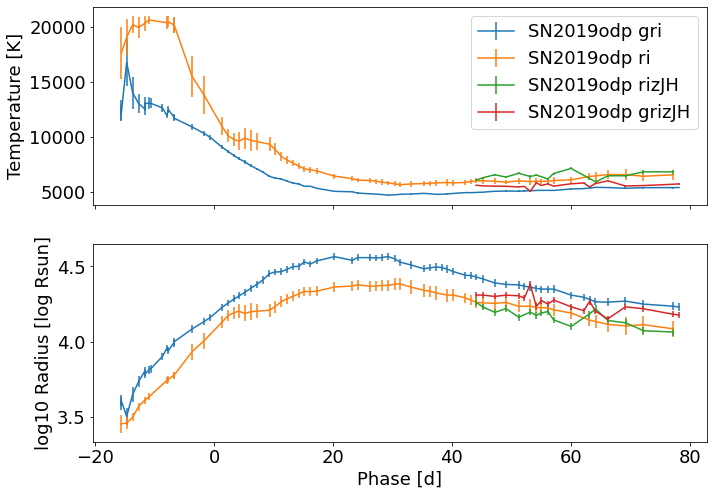

In [6]:
plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11, 8))

#bbfit.run_observation_grid(dataset.load_dataset('SN2008D'), 'Vri', progressbar=False)

plot_ds(dataset.load_dataset('SN2019odp_phot'), ax1, ax2, 'gri', fine=True)
plot_ds(dataset.load_dataset('SN2019odp_phot'), ax1, ax2, 'ri', fine=True)
plot_ds(dataset.load_dataset('SN2019odp_phot'), ax1, ax2, 'rizJH', fine=True)
plot_ds(dataset.load_dataset('SN2019odp_phot'), ax1, ax2, 'grizJH', fine=True)
#plot_ds(dataset.load_dataset('SN2019odp_phot'), ax1, ax2, 'gri', fine=True)
#plot_ds(data_13bvn_ri, ax1, ax2, 'iPTF13bvn ri', 56477)
#plot_ds(data_08d_ri, ax1, ax2, 'SN2008D ri', 54493)

ax1.set_ylabel('Temperature [K]')
ax1.legend()
#ax1.grid(ls='--')
#ax1.set_ylim((4000, 15000))

ax2.set_ylabel('log10 Radius [log Rsun]')
ax2.set_xlabel('Phase [d]')
#ax2.grid(ls='--')
#fig.savefig('2023-02-23-bbfit-filter-comparison.png')
fig.savefig('../paper/plots/phot/bb_fit_validation_filter_comparison.png')